In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

In [2]:
env = 'prod'
model_type = 'XGBoost'

In [3]:
import joblib

clf = joblib.load(f'../../MODELS/model.joblib')

C:\Users\voliveira\OneDrive - Corporacion Empresarial Altra SL\00-Proyectos\myzone\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [4]:
from src.utils import load_config

training_config = load_config(file_name="training_config", env=env, folder='../../config')

In [5]:
import pandas as pd

X = pd.read_parquet(f"../../output_data/{env}/supervised_dataset.parquet")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
)

In [7]:
if model_type == "XGBoost":
    X_test = np.vstack(X_test[training_config.training[model_type].features].values)
    y_test = y_test.values
    X_cp = np.vstack(X_cp[training_config.training[model_type].features].values)
    y_cp = y_cp.values

In [8]:
# Evaluate the model
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

In [9]:
# Calculate metrics accuracy, precision, recall, f1, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"AUC: {auc}")

Accuracy: 0.6416221985058698
Precision: 0.6428892580660309
Recall: 0.6406438259998225
F1: 0.6412260494436373
AUC: 0.8236989597330808


In [10]:
# Calculate Softmax score
# softmax_score = np.max(y_pred_proba, axis=1)

# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cp, y_cp)

alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [15]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=700,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

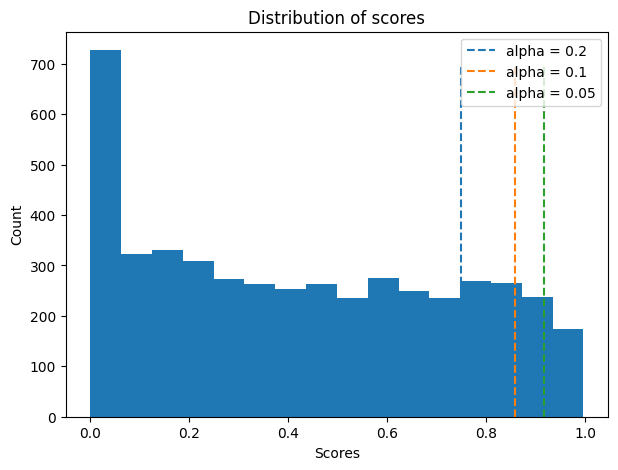

In [16]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)    

In [13]:
quantiles

array([0.74985063, 0.8594601 , 0.91796345], dtype=float32)

In [17]:
1 - quantiles

array([0.25014937, 0.14053988, 0.08203655], dtype=float32)

In [22]:
# Predict set of labels with MAPIE
y_pred = mapie_score.predict(X_test, alpha=0.05)

# Calculate coverage score
coverage = classification_coverage_score(y_test, y_pred[1][:,:,0])

print(f"Coverage: {coverage}")

Coverage: 0.9534685165421558


In [23]:
prediction_sets = pd.DataFrame(y_pred[1][:,:,0])
prediction_sets["set_length"] = prediction_sets.apply(lambda x: sum(x), axis=1)
prediction_sets

,0,1,2,set_length
0,False,True,False,1
1,True,True,True,3
2,True,True,False,2
3,True,True,True,3
4,True,True,False,2
...,...,...,...,...
4680,True,True,True,3
4681,False,False,True,1
4682,True,True,True,3
4683,True,True,True,3


<Axes: xlabel='set_length'>

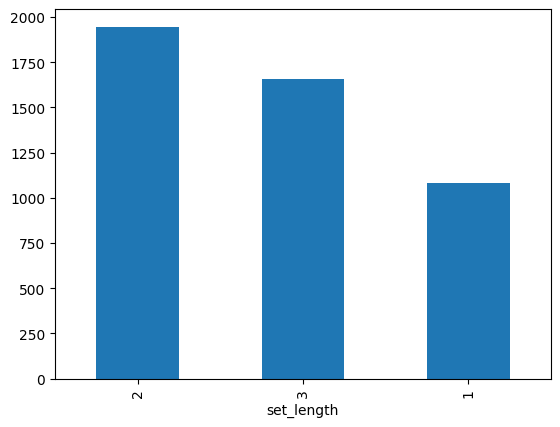

In [24]:
prediction_sets["set_length"].value_counts().plot(kind='bar')

In [120]:
# Create a toy dataset with 2 features and 3 classes (0, 1, 2) with a bit of noise
n_samples = 1500
n_features = 2
n_classes = 3

X = np.random.randn(n_samples, n_features)
y = np.zeros(n_samples)

for i in range(n_classes):
    X[y == i] += np.random.randn(1, n_features) * 1.2

y = np.where(X[:, 0] > 0, 0, 1)
y = np.where(X[:, 1] > 0, y, y + 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Train a Gaussian Naive Bayes classifier
clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

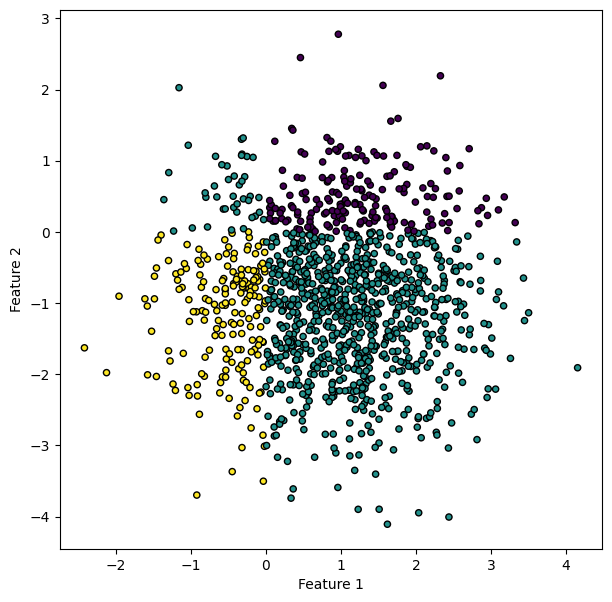

In [121]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, cmap='viridis', edgecolor='k', linewidth=1)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [122]:
# Predict class labels and probabilities
y_pred_proba = clf.predict_proba(X_test)

# Calculate Softmax score
softmax_score = np.max(y_pred_proba, axis=1)

# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)

alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [123]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=50,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

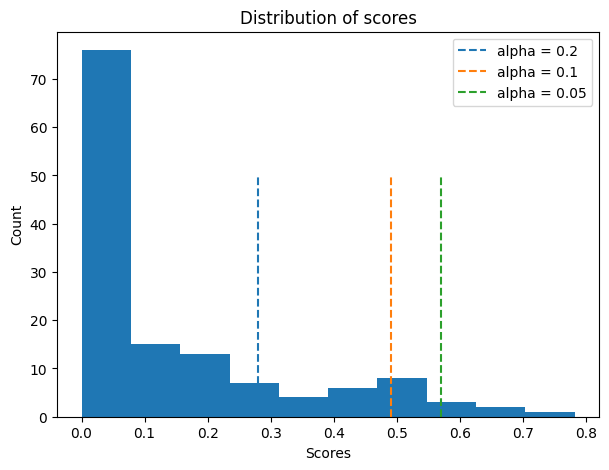

In [124]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)